### Test de pertinence des 2 méthodes: AICC et LRT

Notre méthode va consister à simuler plusieurs écoulements avec un débit **q** transversal variant de $10^{-11}$ à $10^{-3}$. 

Pour chacun de ces débit, on applique nos méthodes AICC et LRT afin de savoir ce qu'elles prédisent. 

On tracera ensuite les prédictions des 2 modèles en fonction de **q** afin de déterminer leurs caractéristiques et les valeurs limites de **q**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyheatmy import *
from datetime import datetime, timedelta
import os, csv
import pandas as pd

from IPython.display import display, Markdown
from frequency_updated import frequentiel_analysis


On écrit ici une fonction qui automatise, à partir de q simplement, un jeu de données, une observation aux différentes profondeurs, ainsi que la transformée de Fourier.

On retourne en sortie l'objet fa qui appartient à la classe "frequentiel_analysis" (définie dans le notebook "frequency_updated"), qui contient les 4 valeurs d'amplitude qui m'intéresse. On renvoit aussi en sortie "depths" qui est simplement les profondeurs des capteurs.

In [2]:
def generate_fa(q):
    Zbottom = 0.4  # 
    depth_sensors = [0.1, 0.2, 0.3, 0.4]

    Layer1 = Layer.from_dict({
    "name": "Sable homogène",
    "zLow": Zbottom,
    "moinslog10IntrinK": 12,
    "n": 0.1,
    "lambda_s": 1.0,
    "rhos_cs": 4e6,
    "q": q,
    })

    t_debut = (2011,1,1); t_fin = (2011,2,28,23,59,59)
    dt = 15*NSECINMIN  # pas de 15 s
    T_riv_amp, T_riv_offset = 1, 12 + ZERO_CELSIUS
    nday = 1
    P_T_riv = nday*NHOURINDAY*4*dt  # période ≈ 1 jour

    time_series_dict = {
        "offset": 0.0,
        "depth_sensors": depth_sensors,
        "param_time_dates": [t_debut, t_fin, dt],
        "param_dH_signal": [0, -9999, 0.05],
        "param_T_riv_signal": [[T_riv_offset], [T_riv_amp, P_T_riv, 0], [1, P_T_riv*30, 0]],
        "param_T_aq_signal": [[T_riv_offset], [0, -9999, 0]],
    }
    emu = synthetic_MOLONARI.from_dict(time_series_dict)

    col = Column.from_dict({
    "river_bed": 1,
    "depth_sensors": depth_sensors,
    "offset": 0.0,
    "dH_measures": emu._molonariP_data,
    "T_measures": emu._T_Shaft_measures,
    "nb_cells": 100,
    "sigma_meas_P": 0.01,
    "sigma_meas_T": 0.1,
    }, verbose=False)

    col.set_layers(Layer1)
    col.compute_solve_transi()
    emu._measures_column_one_layer(col)

    dates = emu._dates
    river = emu._T_riv
    temps_all = col.get_temperature_at_sensors()
    signals = [river] + [temps_all[i, :] for i in range(1, temps_all.shape[0]-1)]
    depths = [0.0] + list(depth_sensors)

    fa = frequentiel_analysis()
    fa.fft_sensors(dates, signals, depths)
    
    depths = np.array(depth_sensors)

    dominant_periods_days, dominant_freqs, dominant_amps, meta = fa.find_dominant_periods(signals, river, draw=True)

    dominant_periods_days = dominant_periods_days[meta['accepted_mask']]
    dominant_freqs = dominant_freqs[meta['accepted_mask']]
    dominant_amps = dominant_amps[meta['accepted_mask']]

    a_est, a_R2 = fa.estimate_a(dates, signals, depths, dominant_periods_days, draw=True)
    b_est, b_R2 = fa.estimate_b(dates, signals, depths, dominant_periods_days, draw=True)
    #On utilise ces méthodes pour que fa ait accès à fa._AMPL_AT_PEAKS_, qui est définit uniquement lorsqu'on utilise fa.estimate_a
    return depths, fa

On définit ici les 2 modèles, LRT et AICC.

Elles sont présentées dans le papier de Moonz. Vous pouvez aller voir directement sur le PDF.

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import chi2

def rss_score(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)


def regression_poly(reg, z_values, deg, show_plot=False, coeff_value=False):
    #fft puis ln amplitude et on a les 4 points dans le tableau reg
    coeffs = np.polyfit(z_values, reg, deg)
    p = np.poly1d(coeffs)

    # Prédictions
    y_pred = p(z_values)
    r2 = r2_score(reg, y_pred)
    if show_plot:
        plt.scatter(z_values, reg, label='Données FFT mesurées')
        plt.plot(z_values, y_pred, 'r--', label=f'Ajustement poly {deg}: R²={r2:.3f}')
        plt.xlabel('Profondeur z (m)')
        plt.ylabel('Log amplitude ln(A(z))')
        plt.title(f"Régression polynomiale de degré {deg}, Le r carré vaut {r2:.3f}")
        plt.show()
    if coeff_value:
        return coeffs, r2, rss_score(reg, y_pred)
    else:
        return r2, rss_score(reg, y_pred)

    


def critere_AICC(reg, z_values, t_sigma, show = False):
    vraisemblance = []
    for deg in range(1, 3):
        _, rss = regression_poly(reg, z_values, deg)
        L = -0.5 * len(z_values) * np.log(2*np.pi*t_sigma**2)- 0.5*rss/(t_sigma**2)
        vr = 2*deg - 2*L+(2*deg)*(deg+1)/(len(z_values)-deg)
        vraisemblance.append(vr)
    min = np.inf
    for i in range(len(vraisemblance)):
        if vraisemblance[i] < min:
            min = vraisemblance[i]
            deg = i + 1
    if deg == 1:
        if show == True:
            print("Modèle linéaire et donc modèle 1D validé préféré selon le critère d'information d'Akaike corrigé (AICc).")
            return("1D")
        else:
            return("1D")
    else:
        if show == True:
            print("Modèle non linéaire et donc modèle 2D préférable selon le critère d'information d'Akaike corrigé (AICc).")
            return("2D")
        else:
            return("2D")


def critere_LRT(reg, z_values, show = False):
    RSS = []
    for deg in range(1, 3):
        _, RSS1 = regression_poly(reg, z_values, deg)
        RSS.append(RSS1)
    
    LRT = 2 * np.log(RSS[0] / RSS[1])
    df = 1
    p_value = 1 - chi2.cdf(LRT, df)

    if p_value < 0.05:
        if show == True:
            print("Modèle non linéaire et donc modèle 2D préféré selon le critère d'information LRT")
            return("2D")
        else:
            return("2D")
    else:
        if show == True:
            print("Modèle linéaire et donc modèle 1D préférable selon le critère d'information LRT")
            return("1D")
        else:
            return("1D")

Ici une micro-fonction qui mets mon résultat **fa._AMPS_AT_PEAK** au bon format, car il nous renvoie une liste de liste de taille 1. On prend ensuite le log du rapport entre l'amplitude et celle initiale.

In [4]:
def traitement_ln(brut):
    traite = []
    for i in range (len(brut)):
        traite.append(np.log(brut[i][0]/brut[0][0]))
    return traite


On parcourt ici 100 valeurs de q, et on remplit un tableau en fonction de ce que le modèle prédit.

Simple problème: La génération d'une colonne, d'une couche ainsi que la résolution prennent beaucoup de temps. 

Ainsi, ceci à pris 22 minutes à tourner. De plus, il plot beaucoup de graphes qui sont automatiquement plot dans les différentes classes, à part cela, le code marche bien !

**Important :**

J'ai sauvegardé les valeurs de LRT et AICC dans le fichier csv: "comparaison_LRT_AICC.csv" pour ne pas avoir à relancer la simulation (elle a duré 20 minutes sur mon ordi)

In [ ]:
"""q_values = np.logspace(-11, -3, num = 100)
LRT = np.ones(len(q_values))
AICC = np.ones(len(q_values))

for j in range(len(q_values)):
    depths, fa = generate_fa(q_values[j])
    brut = fa._AMPS_AT_PEAKS
    traite = traitement_ln(brut)
    rep_LRT = critere_LRT(traite, depths,)
    rep_AICC = critere_AICC(traite, depths, 0.3)
    if rep_LRT == "2D":
        LRT[j] = 2
    if rep_AICC == "2D":
        AICC[j] = 2
"""

'q_values = np.logspace(-11, -3, num = 100)\nLRT = np.ones(len(q_values))\nAICC = np.ones(len(q_values))\n\nfor j in range(len(q_values)):\n    depths, fa = generate_fa(q_values[j])\n    brut = fa._AMPS_AT_PEAKS\n    traite = traitement_ln(brut)\n    rep_LRT = critere_LRT(traite, depths,)\n    rep_AICC = critere_AICC(traite, depths, 0.3)\n    if rep_LRT == "2D":\n        LRT[j] = 2\n    if rep_AICC == "2D":\n        AICC[j] = 2\n'

On trace ici les prédictions des 2 modèles.

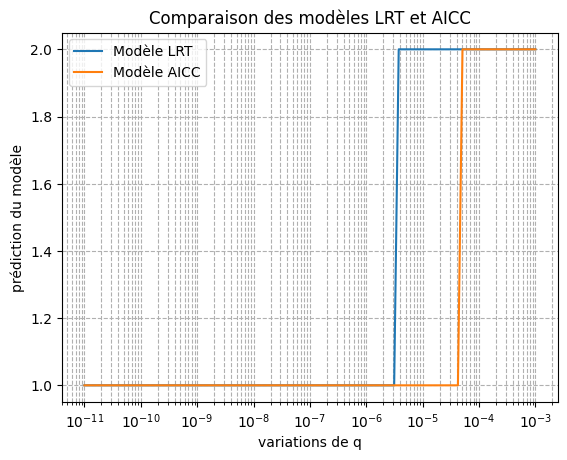

In [23]:
df = pd.read_csv("comparaison_LRT_AICC.csv")
q_values = df['q_values']
plt.figure()

# Tracer les deux courbes
plt.plot(q_values, df["LRT"], label='Modèle LRT')
plt.plot(q_values, df["AICC"], label='Modèle AICC')


# Mettre l’axe des x en échelle logarithmique
plt.xscale('log')

# Ajouter titres, labels et légende
plt.xlabel("variations de q")
plt.ylabel("prédiction du modèle")
plt.title('Comparaison des modèles LRT et AICC')
plt.legend()
plt.grid(True, which="both", ls="--")

# Affichage
plt.show()

On récupère la valeur de débit à partir de laquelle les modèles prédisent un écoulement 2D

In [24]:

i_LRT = 0
j_AICC = 0
while df['LRT'][i_LRT] == 1:
    i_LRT += 1
while df['AICC'][j_AICC] == 1:
    j_AICC += 1
print(f"La valeur de débit à partir duquel LRT donne un écoulement 2D est {q_values[i_LRT]}")
print(f"La valeur de débit à partir duquel AICC donne un écoulement 2D est {q_values[j_AICC]}")


La valeur de débit à partir duquel LRT donne un écoulement 2D est 3.764935806792471e-06
La valeur de débit à partir duquel AICC donne un écoulement 2D est 5.0941380148163855e-05


# Création d'un critère à la main

On part simplement du critère des $r^2$, mais on l'adapte légèrement.

Une régression de degrès supérieur aura forcément un avantage sur celles de degrès inférieur (degrès de liberté en plus). On part donc du principe que si le $r^2$ de la régression linéaire est plus grand que $0.99$, alors on choisit le modèle 
1D.

Sinon, on compare les deux $r^2$, et si celui du modèle 2D est supérieur à celui du 1D ET que le coefficient en $X^2$ est plus grand que $0.1$, alors on choisit le 2D.

In [25]:
def critere_maison(reg, z_values, show_reg=False):
    r2_list = []
    coeffs = []
    for deg in range(1, 3):
        coeff, r2, _ = regression_poly(reg, z_values, deg, coeff_value=True, show_plot= show_reg)
        r2_list.append(r2)
        coeffs.append(coeff)
    if r2_list[0] > 0.99:
        modele = "1D"
    elif r2_list[1] > r2_list[0] and np.absolute(coeffs[1][0])> 0.1:
        modele = "2D"
    else:
        modele = "1D"
    return modele

Idem que pour les 2 critères précédents, le calcul avec les 100 valeurs de q prend du temps. J'ai enregistré les résultats dans "critère_maison.csv"

In [26]:
"""
q_values = np.logspace(-11, -3, num = 100)
maison = np.ones(len(q_values))


for j in range(len(q_values)):
    depths, fa = generate_fa(q_values[j])
    brut = fa._AMPS_AT_PEAKS
    traite = traitement_ln(brut)
    rep_maison = critere_maison(traite, depths,)
    if rep_maison == "2D":
        maison[j] = 2
"""
    

'\nq_values = np.logspace(-11, -3, num = 100)\nmaison = np.ones(len(q_values))\n\n\nfor j in range(len(q_values)):\n    depths, fa = generate_fa(q_values[j])\n    brut = fa._AMPS_AT_PEAKS\n    traite = traitement_ln(brut)\n    rep_maison = critere_maison(traite, depths,)\n    if rep_maison == "2D":\n        maison[j] = 2\n'

On plot la courbe du critère maison

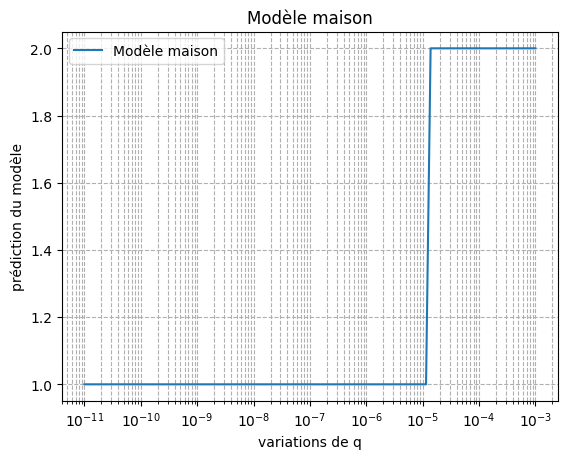

In [27]:
df_2 = pd.read_csv("critere_maison.csv")
q_values = df_2['q_values']
maison = df_2['maison']

plt.figure()

# Tracer les deux courbes
plt.plot(q_values, maison, label='Modèle maison')


# Mettre l’axe des x en échelle logarithmique
plt.xscale('log')

# Ajouter titres, labels et légende
plt.xlabel("variations de q")
plt.ylabel("prédiction du modèle")
plt.title('Modèle maison')
plt.legend()
plt.grid(True, which="both", ls="--")

# Affichage
plt.show()


# Comparaison des 3 critères

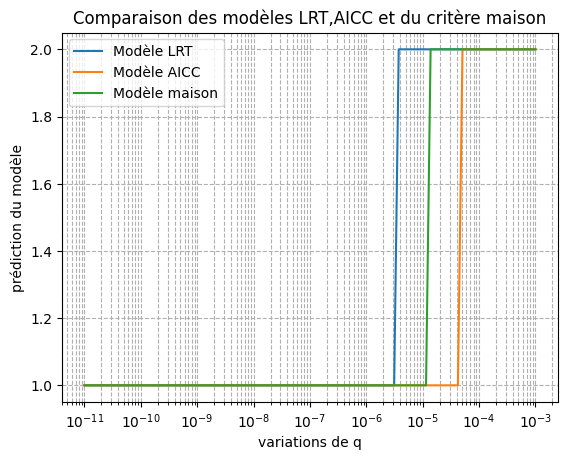

In [28]:
plt.figure()

# Tracer les deux courbes
plt.plot(q_values, df["LRT"], label='Modèle LRT')
plt.plot(q_values, df["AICC"], label='Modèle AICC')
plt.plot(q_values, df_2["maison"], label='Modèle maison')

# Mettre l’axe des x en échelle logarithmique
plt.xscale('log')

# Ajouter titres, labels et légende
plt.xlabel("variations de q")
plt.ylabel("prédiction du modèle")
plt.title('Comparaison des modèles LRT,AICC et du critère maison')
plt.legend()
plt.grid(True, which="both", ls="--")

# Affichage
plt.show()